# Introduction and import libraries

In [13]:
import tensorflow as tf
from tensorflow import keras as keras
print(tf.__version__)

print(keras.__version__)

2.9.2
2.9.0


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import itertools
%matplotlib inline

sns.set(style='white', context='notebook', palette='deep')

In [15]:
from tensorflow.python.keras.utils import np_utils

import numpy as np

# Data preparation
## Load data

In [18]:
data_path = os.path.join("datasets")
def load_data(filename, data_path=data_path):
    csv_path = os.path.join(data_path, filename)
    df = pd.read_csv(csv_path, sep = ",")
    return df

In [19]:
train_data = load_data("train.csv")
test_data = load_data("test.csv")

In [20]:
y = train_data["label"]#.to_numpy()
X = train_data.drop(["label"], axis=1)#.to_numpy()

[]

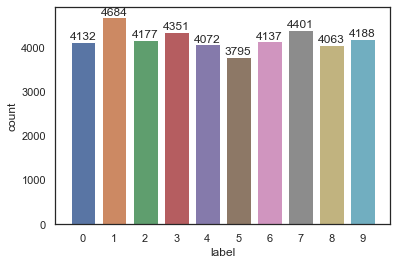

In [21]:
%%capture --no-display
g = sns.countplot(y)
g.bar_label(g.containers[0])
g.plot()

Conlusion: Dataset is balanced

## Missing values

In [22]:
# Check the data
X.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [23]:
test_data.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

Conlusion: There is no missing values in the train and test dataset.

## Normalization

CNN converg faster on [0..1] data than on [0..255].

In [24]:
X = X / 255.0
test_data = test_data / 255.0

## Reshape and label encoding

In [25]:
X = X.values.reshape(-1, 28, 28, 1)
test_data = test_data.values.reshape(-1, 28, 28, 1)
y = np_utils.to_categorical(y)

print(X.shape)
print(X.shape)
print(np.unique(y,return_counts=True))
print(X[0].shape)

nb_classes = len(np.unique(y))
n_samples = X.shape[0]

(42000, 28, 28, 1)
(42000, 28, 28, 1)
(array([0., 1.], dtype=float32), array([378000,  42000]))
(28, 28, 1)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


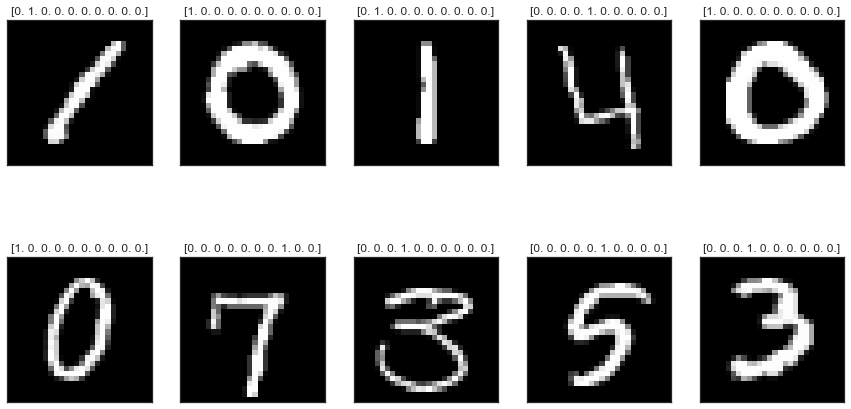

In [26]:
fig, axes = plt.subplots(2, 5, figsize=(15, 8), subplot_kw={'xticks': (), 'yticks': ()})
for target, image, ax in zip(y, X, axes.ravel()):
    ax.imshow(image.reshape(28, 28), cmap=plt.cm.gist_gray)
    ax.set_title(target)
plt.show() 

## Split training and validation dataset

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# CNN

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.callbacks import History
from keras.preprocessing.image import ImageDataGenerator

In [29]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

history_1 = History()

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

## Set the optimizer and annealer

Once our layers are added to the model, we need to set up a score function, a loss function and an optimisation algorithm:
* loss function - funkcja ta definiuje sposób pomiaru wydajności sieci podczas przetwarzania treningowego zbioru danych, a więc pozwala na dostrajanie parametrów sieci we właściwym kierunku,
* optimizer - mechanizm dostrajania sieci na podstawie danych zwracanych przez funkcję straty,
* metrics - metryki monitorowane podczas trenowania i testowania.

We define the loss function to measure how poorly our model performs on images with known labels. It is the error rate between the oberved labels and the predicted ones. We use a specific form for categorical classifications (>2 classes) called the "categorical_crossentropy".

The most important function is the optimizer. This function will iteratively improve parameters (filters kernel values, weights and bias of neurons ...) in order to minimise the loss.

I choosed adam (with default values), it is a very effective optimizer.

The metric function "accuracy" is used is to evaluate the performance our model. This metric function is similar to the loss function, except that the results from the metric evaluation are not used when training the model (only for evaluation).

In [30]:
# Compile the model
model.compile(optimizer = "adam" , loss = "categorical_crossentropy", metrics=["accuracy"])

In [31]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

## Data augmentation

In [32]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [234]:
# Fit the model
early_stopping = EarlyStopping(patience=5, monitor="val_loss")
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
                              epochs = 100, validation_data = (X_val,y_val),
                              callbacks=[learning_rate_reduction, early_stopping, history_1])

Epoch 1/100


/var/folders/dd/nn1g8pns4f18myq4q6z84swh0000gn/T/ipykernel_7929/3848252129.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/preprocessing/image.py:2324: DeprecationWarning: Please use `affine_transform` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  channel_images = [ndimage.interpolation.affine_transform(  # pylint: disable=g-complex-comprehension


1182/1182 [==============================] - 49s 41ms/step - loss: 0.3410 - accuracy: 0.8908 - val_loss: 0.0551 - val_accuracy: 0.9843 - lr: 0.0010
Epoch 2/100
1182/1182 [==============================] - 51s 43ms/step - loss: 0.1287 - accuracy: 0.9621 - val_loss: 0.0413 - val_accuracy: 0.9890 - lr: 0.0010
Epoch 3/100
1182/1182 [==============================] - 49s 41ms/step - loss: 0.0978 - accuracy: 0.9711 - val_loss: 0.0298 - val_accuracy: 0.9917 - lr: 0.0010
Epoch 4/100
1182/1182 [==============================] - 55s 47ms/step - loss: 0.0810 - accuracy: 0.9762 - val_loss: 0.0334 - val_accuracy: 0.9888 - lr: 0.0010
Epoch 5/100
1182/1182 [==============================] - 54s 46ms/step - loss: 0.0737 - accuracy: 0.9782 - val_loss: 0.0345 - val_accuracy: 0.9919 - lr: 0.0010
Epoch 6/100
1182/1182 [==============================] - 50s 43ms/step - loss: 0.0668 - accuracy: 0.9799 - val_loss: 0.0246 - val_accuracy: 0.9931 - lr: 0.0010
Epoch 7/100
1182/1182 [=============================

In [37]:
model.save('models/mieczmik-mnist-model')
# reconstructed_model = keras.models.load_model('models/mieczmik-mnist-model')

# Evaluate model
## Training and validation curves

NameError: name 'history' is not defined

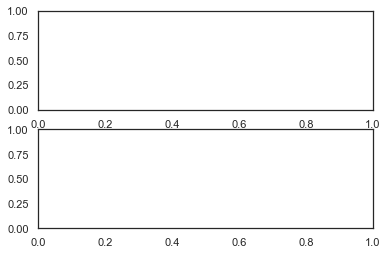

In [6]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## Confusion matrix

132/132 [==============================] - 1s 10ms/step


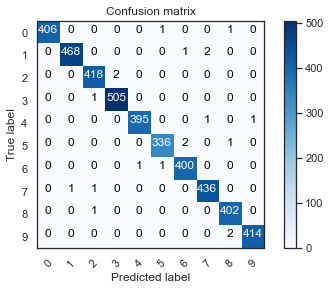

In [38]:
from sklearn.metrics import confusion_matrix
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

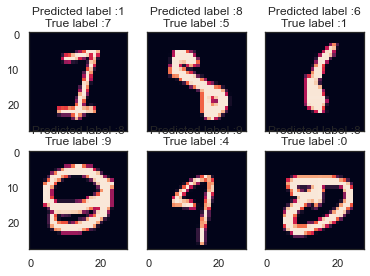

In [39]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [238]:
predictions = np.argmax(model.predict(test_data), axis = 1)
predictions_df = pd.DataFrame(data = predictions)
predictions_df.index = predictions_df.index + 1
predictions_df.to_csv(path_or_buf = "submission/submission.csv", header=["Label"], index=True, index_label="ImageId")

875/875 [==============================] - 16s 18ms/step
